# Simulationg fibrosis

In [2]:
import numpy as np 
import scipy as sp
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

# import sparse matrices
from scipy.sparse import csr_matrix

import os, sys
rootpath = os.path.join(os.getcwd(), '..')
sys.path.append(rootpath)

import networkx as nx

from scipy.sparse import lil_matrix, diags
import sdeint as sde

import jax.numpy as jnp
from diffrax import diffeqsolve, ODETerm, SaveAt, Tsit5, Dopri5
import diffrax
import jax
from jax.experimental import sparse

In [12]:

def graph_laplacian(N, M, boundary_condition="no-flux", sparse_matrix=True, conduction_block_threshold=0.1):
    """
    Create a graph Laplacian using a 9-point stencil with the option to include conduction blocks.
    Includes support for periodic or von Neumann (no-flux) boundary conditions.
    
    Parameters:
    - boundary_condition: Type of boundary condition ("periodic" or "no-flux").
    - sparse_matrix: Whether to return the Laplacian as a sparse matrix.
    - conduction_block_threshold: Probability threshold for defining conduction blocks. 
      Nodes with random values smaller than this threshold are considered conduction blocks.
    
    """
    
    num_nodes = N * M
    adj_matrix = lil_matrix((num_nodes, num_nodes))  

    # Generate random conduction blocks
    conduction_blocks = np.random.rand(N, M) < conduction_block_threshold
    
    def node_index(i, j):
        return i * M + j

    for i in range(N):
        for j in range(M):
            idx = node_index(i, j)
            
            if conduction_blocks[i, j]:
                # Skip this node because it is a conduction block
                continue
            
            # Connect to 8 neighbors (including diagonals), weights according to Oono-Puri
            neighbors = [
                (i - 1, j, .5),     # up
                (i + 1, j, .5),     # down
                (i, j - 1, .5),     # left
                (i, j + 1, .5),     # right
                (i - 1, j - 1, .25), # top-left
                (i - 1, j + 1, .25), # top-right
                (i + 1, j - 1, .25), # bottom-left
                (i + 1, j + 1, .25)  # bottom-right
            ]
            
            for ni, nj, w in neighbors:
                if boundary_condition == "no-flux":
                    # Apply no-flux (Neumann) boundary conditions:
                    if 0 <= ni < N and 0 <= nj < M:
                        if not conduction_blocks[ni, nj]:
                            # Connect only to non-conduction block neighbors inside the grid
                            adj_matrix[idx, node_index(ni, nj)] = w
                
                elif boundary_condition == "periodic":
                    # Apply periodic boundary conditions by wrapping indices
                    ni_wrapped = ni % N
                    nj_wrapped = nj % M
                    if not conduction_blocks[ni_wrapped, nj_wrapped]:
                        adj_matrix[idx, node_index(ni_wrapped, nj_wrapped)] = w

    # Compute degrees (diagonal degree matrix)
    degrees = np.array(adj_matrix.sum(axis=1)).flatten()
    degree_matrix = diags(degrees)
    
    # Laplacian: L = D - A
    laplacian_matrix = degree_matrix - adj_matrix
    
    if sparse_matrix:

        return sparse.BCSR.from_scipy_sparse(laplacian_matrix)
    else:
        return jnp.array(laplacian_matrix.todense())

    


N_x = 200
N_y = 200
N = N_x*N_y
sparse_matrix = True
L1=graph_laplacian(N_x, N_y, boundary_condition="no-flux",sparse_matrix=sparse_matrix, conduction_block_threshold=0)


In [13]:
def FHN_graph(t, y, args):
    N, a, b, e, Du,L= args 
    u = y[:N]
    v = y[N:]
    
    du = a*u*(u-b)*(1-u) - Du*(L@u) - v 
    dv = e*(u-v)

    return jnp.append(du,dv)

In [14]:
@jax.jit
def solve_heart(y0='center-excitation',a=3,b=0.2,e=1e-2,Du=.1,T=300,L=L1, max_steps=1000000, solver=Dopri5(),rtol=1e-3, atol=1e-4,dt0=1e-2):
    if y0 == 'center-excitation':
        y0 = jnp.zeros(2*N)
        center = N//2+N_x//2
        y0 = y0.at[center-1:center+2].set(0.5)
        y0 = y0.at[center-N_x].set(0.5)
        y0 = y0.at[center+N_x].set(0.5)
    
    term = ODETerm(FHN_graph)
    saveat = SaveAt(ts=jnp.linspace(0, T, 100))
    stepsize_controller = diffrax.PIDController(rtol=rtol, atol=atol)

    sol = diffeqsolve(term, solver, 0, T, dt0, y0, args=(N,a,b,e,Du,L), saveat=saveat,max_steps=max_steps, progress_meter=diffrax.TqdmProgressMeter(), stepsize_controller=stepsize_controller)
    return sol

In [15]:
N_x=200
N_y=200
N=N_x*N_y
y0 = np.zeros(2*N)
cells = np.arange(0,N*2,1)
for i in range(N):
    if i%N_x==0:
        y0[i]=0.4

100.00%|██████████| [00:28<00:00,  3.46%/s]


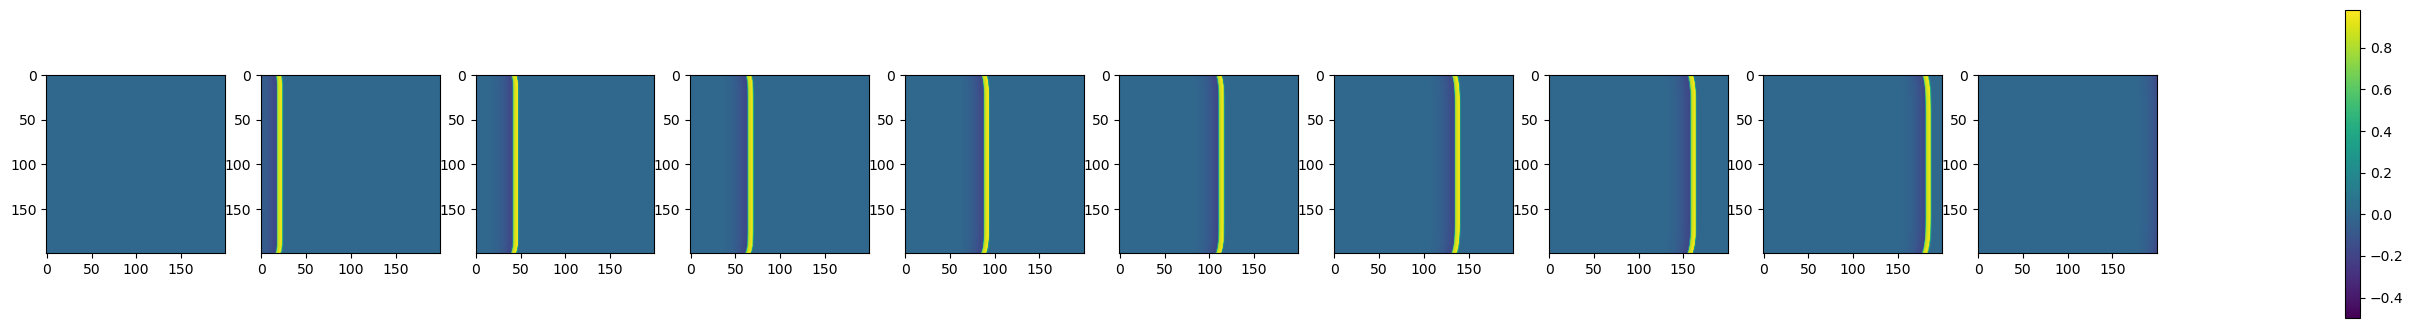

In [16]:
#First simulation without any conduction blockages
sol = solve_heart(y0=y0,T=1800)
fig, axs = plt.subplots(1,11,figsize=(30,4))
min = sol.ys.min()
max = sol.ys.max()
for i, ax in enumerate(axs[:-1]):
    im = ax.imshow(sol.ys[int((i/len(axs)*len(sol.ts))),:N].reshape(N_x,N_y), vmin=min,vmax=max)
axs[-1].axis('off')
fig.colorbar(im, ax=axs[-1])

All actvity disappears after T=1800 when there are no conduction blockages

In [33]:
#simulation with conduction blockages generating reentry
L1=graph_laplacian(N_x, N_y, boundary_condition="no-flux",sparse_matrix=True, conduction_block_threshold=0.12)


100.00%|██████████| [01:10<00:00,  1.42%/s]


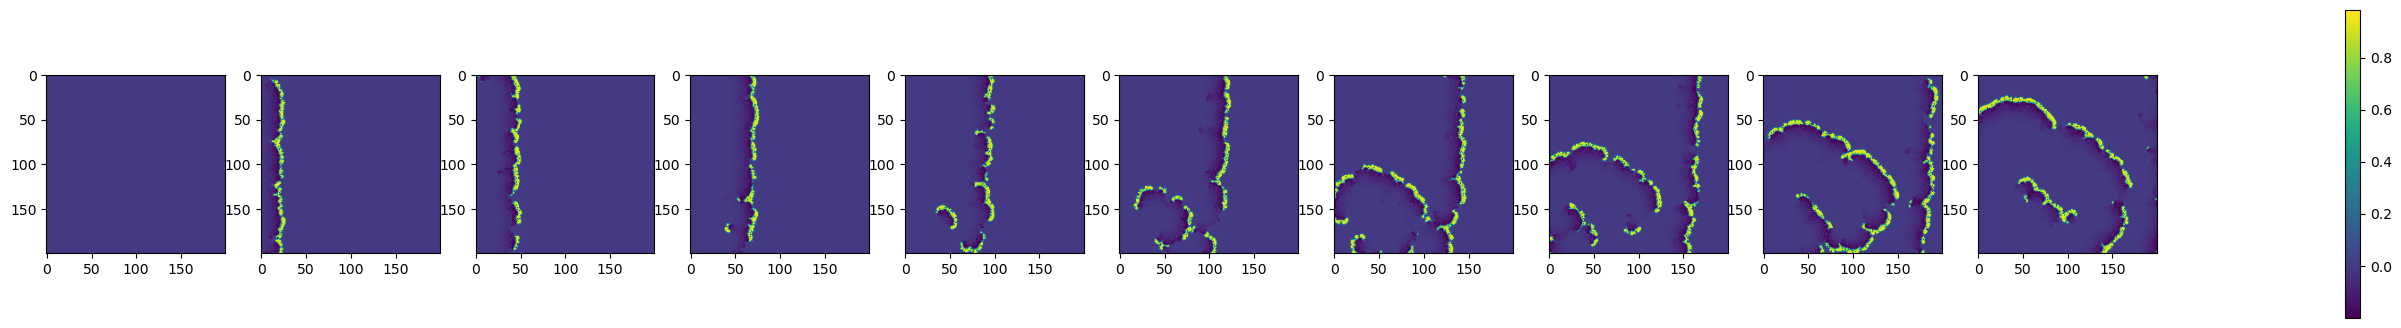

In [34]:
sol = solve_heart(y0=y0,T=2500, L=L1)
fig, axs = plt.subplots(1,11,figsize=(30,4))
min = sol.ys.min()
max = sol.ys.max()
for i, ax in enumerate(axs[:-1]):
    im = ax.imshow(sol.ys[int((i/len(axs)*len(sol.ts))),:N].reshape(N_x,N_y), vmin=min,vmax=max)
axs[-1].axis('off')
fig.colorbar(im, ax=axs[-1])

I get reentry for values in between 1 and 2 approximately (I need to explore the range more systematically and average over multiple simulations). Reentry means that I get sustained activity in the frame even when the wave without any obstacles would have arrived on the other side of the frame (But I need to be careful with this because including some obstacles the wave slows down).